### Go to project root

In [1]:
import os
from pathlib import Path

#list the current work dir
cwd = os.getcwd()
current_path = Path(cwd)
project_root = current_path.parent.parent.parent
print(project_root)

#change the current work dir
os.chdir(project_root)

/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy


### Imports

In [ ]:
!pip install mplfinance

In [2]:
from trazy_analysis.common.ccxt_connector import CcxtConnector
from trazy_analysis.models.asset import Asset
from datetime import datetime
from trazy_analysis.market_data.historical.ccxt_historical_data_handler import CcxtHistoricalDataHandler
from collections import deque
from trazy_analysis.feed.feed import Feed, CsvFeed
import pytz
import numpy as np
import pandas as pd
import math
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc, candlestick2_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
exchange = "BINANCE"

In [4]:
exchanges_api_keys = {
    exchange: {
        "key": None,
        "secret": None,
        "password": None,
    }
}

ccxt_connector = CcxtConnector(exchanges_api_keys=exchanges_api_keys)
historical_data_handler = CcxtHistoricalDataHandler(ccxt_connector)

In [ ]:
start = datetime(2021, 11, 29, 0, 0, 0, 0, tzinfo=pytz.UTC)
end = datetime(2021, 12, 5, 0, 0, 0, 0, tzinfo=pytz.UTC)

In [5]:
exchange_asset = Asset(symbol="BTC/USDT", exchange=exchange)

In [ ]:
historical_data_handler.save_ticker_data_in_csv(
    exchange_asset, "trazy_analysis/strategy_ideas/bob_volman_pattern_break/data/btc_usdt_tight_trading_range.csv", start, end
)

In [6]:
# load data
events = deque()
feed: Feed = CsvFeed(
    {
        exchange_asset: f"trazy_analysis/strategy_ideas/bob_volman_pattern_break/data/btc_usdt.csv"
    },
    events,
)

In [7]:
df = feed.candle_dataframes[exchange_asset]

In [ ]:
from datetime import timedelta
df_5min = df.aggregate(timedelta(minutes=5))

In [ ]:
df_5min

In [8]:
df_sample = df

In [ ]:
df_sample

In [9]:
numeric_df = pd.DataFrame()

In [10]:
numeric_df

""


In [11]:
numeric_df["open"] = pd.to_numeric(df_sample["open"])
numeric_df["high"] = pd.to_numeric(df_sample["high"])
numeric_df["low"] = pd.to_numeric(df_sample["low"])
numeric_df["close"] = pd.to_numeric(df_sample["close"])
numeric_df["volume"] = pd.to_numeric(df_sample["volume"])
numeric_df.index = pd.to_datetime(numeric_df.index)
numeric_df['date'] = mpl_dates.date2num(numeric_df.index)

In [ ]:
class real_time_peak_detection():
    def __init__(self, array, lag, threshold, influence):
        self.y = list(array)
        self.length = len(self.y)
        self.lag = lag
        self.threshold = threshold
        self.influence = influence
        self.signals = [0] * len(self.y)
        self.filteredY = np.array(self.y).tolist()
        self.avgFilter = [0] * len(self.y)
        self.stdFilter = [0] * len(self.y)
        self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
        self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

    def thresholding_algo(self, new_value):
        self.y.append(new_value)
        i = len(self.y) - 1
        self.length = len(self.y)
        if i < self.lag:
            return 0
        elif i == self.lag:
            self.signals = [0] * len(self.y)
            self.filteredY = np.array(self.y).tolist()
            self.avgFilter = [0] * len(self.y)
            self.stdFilter = [0] * len(self.y)
            self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
            self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
            return 0

        self.signals += [0]
        self.filteredY += [0]
        self.avgFilter += [0]
        self.stdFilter += [0]

        if abs(self.y[i] - self.avgFilter[i - 1]) > self.threshold * self.stdFilter[i - 1]:
            if self.y[i] > self.avgFilter[i - 1]:
                self.signals[i] = 1
            else:
                self.signals[i] = -1

            self.filteredY[i] = self.influence * self.y[i] + (1 - self.influence) * self.filteredY[i - 1]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
        else:
            self.signals[i] = 0
            self.filteredY[i] = self.y[i]
            self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
            self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

        return self.signals[i]

In [ ]:
r = real_time_peak_detection(numeric_df['close'].iloc[0:30], 5, 0, 0)

In [ ]:
for i in range(30, 40):
    print(r.thresholding_algo(numeric_df['close'].iloc[i]))

In [ ]:
r.signals

In [12]:
from scipy.signal import argrelextrema

x_max = np.array(numeric_df['high'])
x_min = np.array(numeric_df['low'])

# for local maxima
maximas = argrelextrema(x_max, np.greater, order = 3)[0]

# for local minima
minimas = argrelextrema(x_min, np.less)[0]

In [13]:
x_max

array([57432.5 , 57487.24, 57495.  , ..., 49123.75, 49120.01, 49095.85])

In [14]:
maximas

array([   2,   11,   22,   34,   51,   66,   72,   81,   95,  105,  114,
        120,  125,  140,  146,  157,  168,  172,  182,  191,  210,  221,
        232,  236,  245,  267,  276,  283,  287,  303,  308,  317,  325,
        335,  347,  352,  362,  367,  380,  390,  408,  412,  424,  434,
        441,  449,  467,  476,  485,  495,  501,  513,  532,  552,  570,
        577,  587,  596,  600,  609,  622,  629,  637,  652,  661,  669,
        685,  692,  698,  705,  710,  724,  731,  736,  750,  760,  769,
        776,  781,  789,  800,  813,  823,  830,  843,  865,  891,  900,
        912,  920,  937,  961,  971,  979,  986, 1009, 1017, 1022, 1051,
       1055, 1059, 1068, 1075, 1080, 1090, 1097, 1107, 1116, 1129, 1137,
       1166, 1186, 1192, 1203, 1211, 1216, 1230, 1244, 1255, 1268, 1280,
       1290, 1301, 1314, 1325, 1329, 1338, 1348, 1360, 1366, 1387, 1404,
       1410, 1425, 1434, 1440, 1457, 1470, 1484, 1492, 1500, 1505, 1530,
       1540, 1545, 1554, 1574, 1581, 1590, 1604, 16

In [15]:
minimas

array([   2,    5,    8, ..., 8612, 8614, 8622])

In [16]:
extremas = np.concatenate((maximas, minimas), axis=0)

In [17]:
extremas

array([   2,   11,   22, ..., 8612, 8614, 8622])

In [18]:
sorted_extremas = np.sort(extremas) 

In [19]:
sorted_extremas

array([   2,    2,    5, ..., 8618, 8622, 8625])

/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy/trazy_analysis/env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy/trazy_analysis/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/moussadiakite/Google_Drive/Projects/MInvest/Trazy/trazy_analysis/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, 

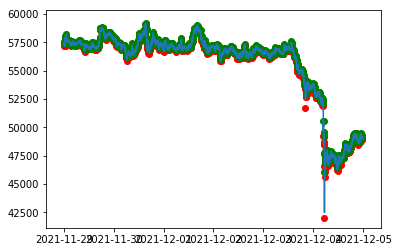

In [20]:
numeric_df['min'] = numeric_df.iloc[argrelextrema(x_min, np.less)[0]]['low']
numeric_df['max'] = numeric_df.iloc[argrelextrema(x_max, np.greater)[0]]['high']

# Plot results

plt.scatter(numeric_df.index, numeric_df['min'], c='r')
plt.scatter(numeric_df.index, numeric_df['max'], c='g')
plt.plot(numeric_df.index, numeric_df['close'])
plt.show()

In [21]:
numeric_df.head()

,open,high,low,close,volume,date,min,max
timestamp,,,,,,,,
2021-11-29 00:00:00+00:00,57274.89,57432.50,57274.88,57415.37,99.98015,738123.000000,NaN,NaN
2021-11-29 00:01:00+00:00,57415.37,57487.24,57371.95,57446.34,59.95392,738123.000694,NaN,NaN
2021-11-29 00:02:00+00:00,57443.86,57495.00,57361.69,57459.01,87.33599,738123.001389,57361.69,57495.00
2021-11-29 00:03:00+00:00,57451.77,57481.34,57407.25,57470.61,60.91451,738123.002083,NaN,NaN
2021-11-29 00:04:00+00:00,57470.61,57489.11,57351.51,57362.47,70.33443,738123.002778,NaN,57489.11


In [22]:
numeric_df

,open,high,low,close,volume,date,min,max
timestamp,,,,,,,,
2021-11-29 00:00:00+00:00,57274.89,57432.50,57274.88,57415.37,99.98015,738123.000000,NaN,NaN
2021-11-29 00:01:00+00:00,57415.37,57487.24,57371.95,57446.34,59.95392,738123.000694,NaN,NaN
2021-11-29 00:02:00+00:00,57443.86,57495.00,57361.69,57459.01,87.33599,738123.001389,57361.69,57495.00
2021-11-29 00:03:00+00:00,57451.77,57481.34,57407.25,57470.61,60.91451,738123.002083,NaN,NaN
2021-11-29 00:04:00+00:00,57470.61,57489.11,57351.51,57362.47,70.33443,738123.002778,NaN,57489.11
...,...,...,...,...,...,...,...,...
2021-12-04 23:43:00+00:00,48978.03,49039.82,48978.01,49039.81,13.38917,738128.988194,NaN,NaN
2021-12-04 23:44:00+00:00,49039.81,49105.36,49009.42,49089.45,25.48981,738128.988889,NaN,NaN
2021-12-04 23:45:00+00:00,49089.45,49123.75,49069.51,49114.74,23.63911,738128.989583,NaN,49123.75


In [ ]:
type(numeric_df['close'].iloc[0])

In [ ]:
numeric_df['close'].iloc[sorted_extremas]

In [ ]:
ave =  np.mean(numeric_df['high'] - numeric_df['low']) / 4

# a list to store resistance and support levels
class Level:
    def __init__(self, index, level, level_type):
        self.index = index
        self.level = level
        self.level_type = level_type

    def __hash__(self):
        return 0

    def __eq__(self, other):
        return self.level_type == other.level_type and abs(self.level - other.level) < ave
    
    def __str__(self):
        return f"({self.index}, {self.level}, {self.level_type})"


class LevelInfo:
    def __init__(self):
        self.min_value = float("inf")
        self.max_value = float("-inf")
        self.power = 0
    
    def update(self, value):
        self.min_value = min(self.min_value, value)
        self.max_value = max(self.max_value, value)
        self.power += 1
    
    def __str__(self):
        return f"power: {self.power}, range: [{self.min_value}, {self.max_value}]"

levels = {}

for i in minimas:
    low = numeric_df['low'].iloc[i]
    level = Level(i, low, "support")
    print(f"Take into account {str(level)}")
    keys = list(levels.keys())
    matches = [str(key) for key in keys if key == level]
    print(f"matches = {matches}")
    level_info = levels.get(level, LevelInfo())
    level_info.update(level.level)
    levels.update({level: level_info})
    print({str(level): str(level_info) for level, level_info in levels.items()})

print("----------------------------------------------------------")
for i in maximas:
    high = numeric_df['high'].iloc[i]
    level = Level(i, high, "resistance")
    print(f"Take into account {str(level)}: {str(level)}")
    keys = list(levels.keys())
    matches = [str(key) for key in keys if key == level]
    print(f"matches = {matches}")
    level_info = levels.get(level, LevelInfo())
    level_info.update(level.level)
    levels.update({level: level_info})
    print({str(level): str(level_info) for level, power in levels.items()})

In [ ]:
ave

In [ ]:
numeric_df.values

In [ ]:
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['high'][i] >= df['high'][i-1]   
  cond2 = df['high'][i] >= df['high'][i+1]   
  cond3 = df['high'][i+1] >= df['high'][i+2]   
  cond4 = df['high'][i-1] >= df['high'][i-2]  
  cond5 = True#df['high'][i+2] > df['high'][i+3]   
  cond6 = True#df['high'][i-2] > df['high'][i-3]  
  return (cond1 and cond2 and cond3 and cond4 and cond5 and cond6)

# a list to store resistance and support levels
levels = []
for i in range(2, numeric_df.shape[0] - 2):  
  if is_resistance(numeric_df, i):    
    high = numeric_df['high'][i]         
    levels.append((i, high))

In [ ]:
levels

In [ ]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['low'][i] < df['low'][i-1]   
  cond2 = df['low'][i] < df['low'][i+1]   
  cond3 = df['low'][i] < df['low'][i+2]   
  cond4 = df['low'][i] < df['low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['high'][i] > df['high'][i-1]   
  cond2 = df['high'][i] > df['high'][i+1]   
  cond3 = df['high'][i] > df['high'][i+2]   
  cond4 = df['high'][i] > df['high'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already

levels_power = []
ave =  np.mean(numeric_df['high'] - numeric_df['low']) / 2
def is_far_from_level(value, levels, df):  
  return np.sum([abs(value-level) < ave for _,level in levels])==0

# a list to store resistance and support levels
levels = {}
for i in range(2, numeric_df.shape[0] - 2):  
    if is_support(numeric_df, i):    
        low = numeric_df['low'][i]    
        level = Level(i, low, "support")
        level_info = levels.get(level, LevelInfo())
        level_info.update(level.level)
        levels.update({level: level_info})
    elif is_resistance(numeric_df, i):    
        high = numeric_df['high'][i]    
        #if is_far_from_level(high, levels, numeric_df):      
        level = Level(i, high, "resistance")
        level_info = levels.get(level, LevelInfo())
        level_info.update(level.level)
        levels.update({level: level_info})

In [ ]:
ave

In [ ]:
{str(level): str(level_info) for level, level_info in levels.items()}

In [ ]:
!pip install intervaltree

In [25]:
 from intervaltree import Interval, IntervalTree

In [ ]:
supports = IntervalTree()
resistances = IntervalTree()

In [ ]:
t = IntervalTree()

In [ ]:
t[1:3] = "2"

In [ ]:
len(t[2])

In [ ]:
t.removei(1, 3, "2")

In [ ]:
for level, level_info in levels.items():
    min_value = level_info.min_value
    max_value = level_info.max_value
    print(f"min = {min_value}, max = {max_value}")
    if level.level_type == 'support':
        left = min_value
        if min_value < max_value:
            right = max_value
        else:
            right = min_value + 0.0000001
        supports[left:right] = (level, level_info)
    elif level.level_type == 'resistance':
        right = max_value
        if min_value < max_value:
            left = min_value
        else:
            left = max_value - 0.0000001
        resistances[left:right] = (level, level_info)

In [ ]:
ave

In [ ]:
support_range_values = [(level_info.min_value, level_info.max_value) for level, level_info in levels.items() if level.level_type == 'support']
resistance_range_values = [(level_info.min_value, level_info.max_value) for level, level_info in levels.items() if level.level_type == 'resistance']
support_indexes = [level.index for level, level_info in levels.items() if level.level_type == 'support']
resistance_indexes = [level.index for level, level_info in levels.items() if level.level_type == 'resistance']

In [ ]:
support_min_values = [range_value[0] for range_value in support_range_values]
support_max_values = [range_value[1] for range_value in support_range_values]
resistance_min_values = [range_value[0] for range_value in resistance_range_values]
resistance_max_values = [range_value[1] for range_value in resistance_range_values]

In [ ]:
support_values = [value for value_range in support_range_values for value in value_range]
resistance_values = [value for value_range in resistance_range_values for value in value_range]

In [ ]:
levels_min_values = support_min_values + resistance_min_values
levels_max_values = support_max_values + resistance_max_values
levels_values = support_values + resistance_values

In [ ]:
levels_min_values

In [ ]:
levels_max_values

In [ ]:
levels_values

In [ ]:
import matplotlib.colors as mcolors
import seaborn as sns
color_palette = sns.color_palette("husl", len(levels_values) // 2)
colors = [[mcolors.to_hex(c)] * 2 for c in color_palette]
colors = [color for color_tuple in colors for color in color_tuple]

In [ ]:
colors = ['r'] * len(support_values) + ['g'] * len(resistance_values)

In [ ]:
colors

In [ ]:
s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
fig = mpf.figure(figsize=(16, 9), style=s)
ax = fig.add_subplot(1,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot
#av = fig.add_subplot(2,1,2, sharex=ax)  # volume chart subplot
levels_ranges_len = len(levels_min_values)
for i in range(0, len(support_min_values)):
    ax.fill_between(x=range(support_indexes[i], len(numeric_df)), y1=support_min_values[i], y2=support_max_values[i], color='r', alpha=0.20)
for i in range(0, len(resistance_min_values)):
    ax.fill_between(x=range(resistance_indexes[i], len(numeric_df)), y1=resistance_min_values[i], y2=resistance_max_values[i], color='g', alpha=0.20)
mpf.plot(
    numeric_df,
    #hlines=dict(hlines=levels_values,colors=colors,linestyle='-.'),
    #fill_between=dict(y1=[65500], y2=[65600], color='#f2ad73', alpha=0.20),
    type='candle',
    #title='BTC-USDT',
    mav=(25),
    volume=False,
    ax=ax
)

In [ ]:
def is_consiladating(df):
    recent_candlesticks = df[-4:]
    print(recent_candlesticks)
    
    max_close = recent_candlesticks["close"].max()
    min_close = recent_candlesticks["close"].min()
    
    print("The max close was {} and the min close was {}".format(max_close, min_close))
    
    return min_close > (max_close * 0.995)

In [ ]:
is_consiladating(numeric_df)

In [27]:
class TradingRange:
    def __init__(self, start_index, end_index, low, high):
        self.min_value = low
        self.max_value = high
        self.start_index = start_index
        self.end_index = end_index
        self.length = self.end_index - self.start_index + 1
    
    def __str__(self):
        return f"index range: [{self.start_index}, {self.end_index}], range: [{self.min_value}, {self.max_value}]"

In [ ]:

trading_ranges = IntervalTree()

In [ ]:
t = IntervalTree()
t[2:4] = 2
t[2:4.01] = 3
t[4]

In [ ]:
[i for i in range (1, 10)][2:6]

In [ ]:
recent_candlesticks = numeric_df[434:439]
max_close = recent_candlesticks["close"].max()
min_close = recent_candlesticks["close"].min()
min_close > (max_close * 0.99)

In [ ]:
length = 5
indexes = [False] * length
tighness = 0.99
trading_ranges = IntervalTree()
for i in range(length - 1, len(numeric_df) - 1):
    recent_candlesticks = numeric_df[i + 1 - length: i + 1]
    #print(recent_candlesticks)
    
    max_close = recent_candlesticks["close"].max()
    min_close = recent_candlesticks["close"].min()
    print("The max close was {} and the min close was {}".format(max_close, min_close))
    if min_close > (max_close * tighness):
        start_index = i + 1 - length
        end_index = i
        min_low = recent_candlesticks["low"].min()
        max_high = recent_candlesticks["high"].max()
        trading_range = TradingRange(start_index, end_index, min_low, max_high)
        trading_ranges[start_index:end_index + 1] = trading_range
    indexes.append(min_close > (max_close * tighness))

In [ ]:
length = 5
indexes = [False] * length
tighness = 0.99
trading_ranges = IntervalTree()

def is_inside_bar(previous_low, previous_high, low, high):
    return low > previous_low and high < previous_high


def is_outside_bar(previous_low, previous_high, low, high):
    return is_inside_bar(low, high, previous_low, previous_high)
    
for i in range(1, len(numeric_df)):
    previous_candle = numeric_df.iloc[i - 1]
    candle = numeric_df.iloc[i]
    previous_low = previous_candle["low"]
    previous_high = previous_candle["high"]
    low = candle["low"]
    high = candle["high"]
    if is_inside_bar(previous_low, previous_high, low, high) or \
       is_outside_bar(previous_low, previous_high, low, high):
        start_index = i - 1
        end_index = i
        min_low = min(previous_low, low)
        max_high = max(previous_high, high)
        trading_range = TradingRange(start_index, end_index, min_low, max_high)
        trading_ranges[start_index:end_index + 1] = trading_range

In [ ]:
t = IntervalTree()

In [ ]:
t[2: 5] = 1
t[3: 4] = 2

In [ ]:
t

In [ ]:
def maxOverlap(start,end):
    n= len(start)
    maxa = max(start)# Finding maximum starting time
    maxb = max(end)  # Finding maximum ending time
    maxc=max(maxa,maxb)
    x = (maxc+2)*[0]
    cur=0; idx=0
  
    for i in range(0,n) :# CREATING AN AUXILIARY ARRAY
        x[start[i]]+=1 # Lazy addition
        x[end[i]+1]-=1
       
    maxy=-1
    #Lazily Calculating value at index i
    for i in range(0,maxc+1):
        cur+=x[i]
        if maxy<cur :
            maxy=cur
            idx=i
    return  maxy
    print("Maximum value is: {0:d}".format(maxy),
                     " at position: {0:d}".format(idx))

In [23]:
def overlap(v):
  
    # variable to store the maximum
    # count
    ans = 0
    count = 0
    data = []
  
    # storing the x and y
    # coordinates in data vector
    for i in range(len(v)):
  
        # pushing the x coordinate
        data.append([v[i][0], 'x'])
  
        # pushing the y coordinate
        data.append([v[i][1], 'y'])
  
    # sorting of ranges
    data = sorted(data)
  
    # Traverse the data vector to
    # count number of overlaps
    for i in range(len(data)):
  
        # if x occur it means a new range
        # is added so we increase count
        if (data[i][1] == 'x'):
            count += 1
  
        # if y occur it means a range
        # is ended so we decrease count
        if (data[i][1] == 'y'):
            count -= 1
  
        # updating the value of ans
        # after every traversal
        ans = max(ans, count)
  
    # printing the maximum value
    return ans

In [ ]:
intervals = [(2.1, 6), (4,7), (9, 11), (3, 8)]
start = [interval[0] for interval in intervals]
end = [interval[1] for interval in intervals]
overlap(intervals)

In [30]:
length = 10
indexes = [False] * length
min_overlaps = 10
trading_ranges = IntervalTree()
    
for i in range(length - 1, len(numeric_df) - 1):
    recent_candlesticks = numeric_df[i + 1 - length: i + 1]
    intervals = [(min(row["open"], row["close"]), max(row["open"], row["close"]))  for index, row in recent_candlesticks.iterrows()]
    start = [interval[0] for interval in intervals]
    end = [interval[1] for interval in intervals]
    overlaps = overlap(intervals)
    if overlaps >= min_overlaps:
        start_index = i + 1 - length
        end_index = i
        min_low = recent_candlesticks["low"].min()
        max_high = recent_candlesticks["high"].max()
        trading_range = TradingRange(start_index, end_index, min_low, max_high)
        trading_ranges[start_index:end_index + 1] = trading_range

In [34]:
i = 0
for interval in sorted(trading_ranges):
    start_index, end_index = interval.begin, interval.end
    print(f"{numeric_df.index[end_index]}: {interval.data}")
    print(numeric_df[start_index:end_index])
    if i == 10:
        break

2021-12-04 21:12:00+00:00: index range: [8462, 8471], range: [48928.01, 49210.64]
                               open      high       low     close    volume  \
timestamp                                                                     
2021-12-04 21:02:00+00:00  49205.00  49205.00  49120.82  49135.32  25.25826   
2021-12-04 21:03:00+00:00  49135.26  49210.64  49135.26  49181.50  24.54924   
2021-12-04 21:04:00+00:00  49181.49  49198.81  49100.01  49107.00  20.07389   
2021-12-04 21:05:00+00:00  49107.00  49169.05  49104.10  49166.55  22.48446   
2021-12-04 21:06:00+00:00  49166.55  49174.84  49116.44  49144.08  21.12189   
2021-12-04 21:07:00+00:00  49144.47  49160.37  49105.87  49121.02  21.91763   
2021-12-04 21:08:00+00:00  49121.01  49182.00  49080.01  49162.41  22.84226   
2021-12-04 21:09:00+00:00  49162.41  49198.12  49108.85  49108.86  16.63171   
2021-12-04 21:10:00+00:00  49108.85  49179.60  49102.01  49158.39  22.02259   
2021-12-04 21:11:00+00:00  49158.38  49160.19  48

In [ ]:
indexes

In [ ]:
numeric_df[indexes]

In [ ]:
vlines = list(numeric_df.index[indexes])

In [ ]:
vlines

In [ ]:
mpf.plot(
    numeric_df,
    #hlines=dict(hlines=levels_values,colors=colors,linestyle='-.'),
    #fill_between=dict(y1=[65500], y2=[65600], color='#f2ad73', alpha=0.20),
    vlines=dict(vlines=vlines[0:2],colors=colors,linestyle='-.'),
    type='candle',
    #title='BTC-USDT',
    mav=(25),
    volume=True,
)

In [ ]:
import pandas_ta as ta
import math

In [ ]:
ema_open_df = ta.ema(numeric_df["open"], length=25)
ema_high_df = ta.ema(numeric_df["high"], length=25)
ema_low_df = ta.ema(numeric_df["low"], length=25)
ema_close_df = ta.ema(numeric_df["close"], length=25)

In [ ]:
ema_open_df.iloc[23]

In [ ]:
for t in trading_ranges[40]:
    print(t.data)

In [ ]:
vlines = []                                                                                                     
for i in range(25, len(numeric_df)):
    previous_close = numeric_df["close"].iloc[i - 1]
    open = numeric_df["open"].iloc[i]
    close = numeric_df["close"].iloc[i]
    body = abs(close - open)
    close = numeric_df["close"].iloc[i]
    low = numeric_df["low"].iloc[i]
    high = numeric_df["high"].iloc[i]

    resistance_zones = resistances[high]
    for interval in resistance_zones:
        data = interval.data
        level, level_info = data[0], data[1]
        min_value = level_info.min_value
        max_value = level_info.max_value
        ema_close = ema_close_df.iloc[i]
        ema_slope = (ema_close_df.iloc[i - 1] - ema_close_df.iloc[i - 25]) / 5
        if i > level.index:
            trading_ranges_set = trading_ranges[i - 1]
            if len(trading_ranges_set) != 0:
                for interval in trading_ranges_set:
                    trading_range = interval.data
                    if abs(min_value - ema_close) < body:
                        if not math.isnan(ema_close):
                        #if abs(previous_close - ema_close) < body / 2:
                            if ema_close < min_value:
                                if close < ema_close and close < trading_range.min_value or \
                                   close > max_value and close > trading_range.max_value:
                                    print(f"{trading_range}")
                                    print(f"{numeric_df.index[i]}: {level.level_type}, {str(level_info)}")
                                    print(f"i = {i}")
                                    vlines.append(numeric_df.index[i])
                    break

    support_zones = supports[low]
    for interval in support_zones:
        data = interval.data
        level, level_info = data[0], data[1]
        min_value = level_info.min_value
        max_value = level_info.max_value
        ema_close = ema_close_df.iloc[i]
        ema_slope = (ema_close_df.iloc[i - 1] - ema_close_df.iloc[i - 25]) / 5
        if i > level.index:
            trading_ranges_set = trading_ranges[i - 1]
            if len(trading_ranges_set) != 0:
                for interval in trading_ranges_set:
                    trading_range = interval.data
                    if abs(min_value - ema_close) < body:
                        if not math.isnan(ema_close):
                        #    if abs(previous_close - ema_close) < body / 2:
                            if ema_close > max_value:
                                if close > ema_close and close > trading_range.max_value or \
                                   close < min_value and close < trading_range.min_value:
                                    print(f"{trading_range}")
                                    print(f"{numeric_df.index[i]}: {level.level_type}, {str(level_info)}")
                                    vlines.append(numeric_df.index[i])
                    break

In [ ]:
vlines = []                                                                                                  
for i in range(25, len(numeric_df)):
    previous_close = numeric_df["close"].iloc[i - 1]
    open = numeric_df["open"].iloc[i]
    close = numeric_df["close"].iloc[i]
    body = abs(close - open)
    close = numeric_df["close"].iloc[i]
    low = numeric_df["low"].iloc[i]
    high = numeric_df["high"].iloc[i]
    
    space = body / 4
    resistance_zones = resistances[high - space: high + space]
    support_zones = supports[low - space: low + space]
    if len(resistance_zones) == 0 or len(support_zones) == 0:
        continue
    
    # take lowest resistance level and max support level
    min_value = float("inf")
    min_resistance = None
    max_value = float("-inf")
    max_support = None
    #print(f"i = {i}")
    for interval in resistance_zones:
        data = interval.data
        level, level_info = data[0], data[1]
        #print(str(level))
        if i > level.index:
            if level_info.min_value < min_value:
                min_value = level_info.min_value
                min_resistance = interval

    for interval in support_zones:
        data = interval.data
        level, level_info = data[0], data[1]
        #print(str(level))
        if i > level.index:
            if level_info.max_value > max_value:
                max_value = level_info.max_value
                max_support = interval
        if min_resistance is not None and max_support is not None:
            print(f"{numeric_df.index[i]}")
            print(f"{str(min_resistance.data[0])}")
            print(f"{str(max_support.data[0])}")

In [ ]:
numeric_df.iloc[34]

In [ ]:
!pip install pandas_ta

In [ ]:
mpf.plot(
    numeric_df,
    #hlines=dict(hlines=levels_values,colors=colors,linestyle='-.'),
    #fill_between=dict(y1=[65500], y2=[65600], color='#f2ad73', alpha=0.20),
    vlines=dict(vlines=vlines,colors=colors,linestyle='-.'),
    type='candle',
    #title='BTC-USDT',
    mav=(25),
    volume=True,
)